<a href="https://colab.research.google.com/github/beenleliu/Paddle/blob/master/chaper_two.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

图像分类数据集

In [1]:
pip install d2lzh

In [2]:
pip install mxnet

In [3]:
%matplotlib inline
import d2lzh as d2l
from mxnet.gluon import data as gdata
import sys
import time

In [4]:
mnist_train = gdata.vision.FashionMNIST(train=True) #Training data set
mnist_test = gdata.vision.FashionMNIST(train=False) #Testing data set

In [5]:
#训练集和测试集的样本数量
len(mnist_train),len(mnist_test) 

(60000, 10000)

In [6]:
feature, label = mnist_train[0]

变量feature对应⾼和宽均为28像素的图像,每个像素的数值为0到255之间8位⽆符号整数
（uint8）,使⽤三维的NDArray存储。其中的最后⼀维是通道数,数据集中是灰度图像，
所以通道数为1,将⾼和宽分别为h和w像素的图像的形状记为h×w或（h，w）

In [7]:
feature.shape, type(feature), feature.dtype

((28, 28, 1), mxnet.ndarray.ndarray.NDArray, numpy.uint8)

In [8]:
label, type(label), label.dtype

(2, numpy.int32, dtype('int32'))

Fashion-MNIST中⼀共包括了10个类别，分别为t-shirt（T恤）、trouser（裤⼦）、pullover（套衫）、
dress（连⾐裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle
boot（短靴）。以下函数可以将数值标签转成相应的⽂本标签。

In [9]:
def get_fashion_mnist_labels(labels):
  text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat','sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
  return [text_labels[int(i)] for i in labels]

In [10]:
def show_fashion_mnist(images, labels):
  d2l.use_svg_display()
  # 这⾥的_表⽰我们忽略（不使⽤）的变量
  _, figs = d2l.plt.subplots(1, len(images), figsize=(12, 12))
  for f, img, lbl in zip(figs, images, labels):
    f.imshow(img.reshape((28, 28)).asnumpy())
    f.set_title(lbl)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)


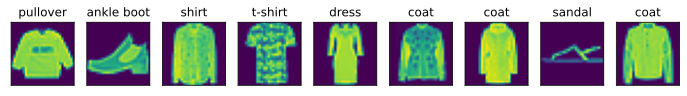

In [11]:
X,y = mnist_train[0:9]
show_fashion_mnist(X, get_fashion_mnist_labels(y))

In [12]:
#读小批量数据
batch_size = 256
transformer = gdata.vision.transforms.ToTensor()
if sys.platform.startswith('win'):
  num_workers = 0
else:
  num_workers = 4
train_iter = gdata.DataLoader(mnist_train.transform_first(transformer),batch_size,shuffle=True,num_workers=num_workers)
test_iter = gdata.DataLoader(mnist_test.transform_first(transformer),batch_size, shuffle=False,num_workers=num_workers)

In [13]:
start = time.time()
for X,y in train_iter:
  continue
'%.2f sec' % (time.time() - start)

'5.87 sec'

**softmax回归的从零开始实现**

In [14]:
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, nd

In [15]:
#读取数据集
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [16]:
#初始化模型参数
num_inputs = 784 #28*28
num_outputs = 10

W = nd.random.normal(scale=0.01, shape=(num_inputs, num_outputs))
b = nd.zeros(num_outputs)
#附上梯度
W.attach_grad()
b.attach_grad()

In [17]:
#实现softmax()
def softmax(X):
  X_exp = X.exp()
  partition = X_exp.sum(axis=1, keepdims=True)
  return X_exp / partition

In [18]:
#定义模型
def net(X):
  return softmax(nd.dot(X.reshape((-1, num_inputs)),W) + b) 

In [19]:
#定义损失函数
y_hat = nd.array([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = nd.array([0, 2], dtype='int32')
nd.pick(y_hat, y)
#交叉熵损失函数
def cross_entropy(y_hat, y):
  return -nd.pick(y_hat, y).log()

In [20]:
#计算分类准确率
def accuracy(y_hat, y):
  return (y_hat.argmax(axis=1) == y.astype('float32')).mean().asscalar()
accuracy(y_hat,y)

0.5

In [21]:
def evaluate_accuracy(data_iter, net):
  acc_sum, n = 0.0, 0
  for X, y in data_iter:
    y = y.astype('float32')
    acc_sum += (net(X).argmax(axis=1) == y).sum().asscalar()
    n += y.size
  return acc_sum / n
  
evaluate_accuracy(test_iter, net)

0.0925

In [22]:
#训练模型
num_epochs, lr = 5, 0.1
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, trainer=None):
  for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for X, y in train_iter:
      with autograd.record():
        y_hat = net(X)
        l = loss(y_hat, y).sum()
      l.backward()
      if trainer is None:
        d2l.sgd(params, lr, batch_size)
      else:
        trainer.step(batch_size) # “softmax回归的简洁实现”⼀节将⽤到
      y = y.astype('float32')
      train_l_sum += l.asscalar()
      train_acc_sum += (y_hat.argmax(axis=1) == y).sum().asscalar()
      n += y.size
    test_acc = evaluate_accuracy(test_iter, net)
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f' % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)


epoch 1, loss 0.7895, train acc 0.744, test acc 0.798
epoch 2, loss 0.5744, train acc 0.811, test acc 0.823
epoch 3, loss 0.5295, train acc 0.824, test acc 0.832
epoch 4, loss 0.5053, train acc 0.830, test acc 0.831
epoch 5, loss 0.4901, train acc 0.835, test acc 0.839


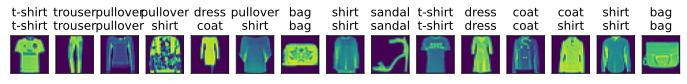

In [27]:
#预测
for X,y in test_iter:
  break
true_labels = d2l.get_fashion_mnist_labels(y.asnumpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1).asnumpy())
titles = [true+'\n'+pred for true, pred in zip(true_labels, pred_labels)]

d2l.show_fashion_mnist(X[0:15], titles[0:15])